In [1]:
import os
import pathlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import random
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Activation, GlobalMaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import splitfolders

In [3]:
# splits dataset it into three subfolders: train, val (validation), and test.

splitfolders.ratio(r"C:\Users\Ajay\Desktop\Aleena\Currency_Dataset", output="output",
    seed=1337, ratio=(.75, .2, .05), group_prefix=None, move=False)

Copying files: 500 files [00:08, 55.62 files/s]


In [4]:
data_dir = pathlib.Path('output/')
train_dir = 'output/train'
val_dir = 'output/val'
test_dir = 'output/test'

In [5]:
class_name = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_name)

['test' 'train' 'val']


In [6]:
for dirpath, dirnames, filenames in os.walk('output'):
  print(f"{len(dirnames)} folder and {len(filenames)} images in {dirpath}")

3 folder and 0 images in output
5 folder and 0 images in output\test
0 folder and 5 images in output\test\100_new
0 folder and 5 images in output\test\200_new
0 folder and 5 images in output\test\20_new
0 folder and 5 images in output\test\500_new
0 folder and 5 images in output\test\50_new
5 folder and 0 images in output\train
0 folder and 75 images in output\train\100_new
0 folder and 75 images in output\train\200_new
0 folder and 75 images in output\train\20_new
0 folder and 75 images in output\train\500_new
0 folder and 75 images in output\train\50_new
5 folder and 0 images in output\val
0 folder and 20 images in output\val\100_new
0 folder and 20 images in output\val\200_new
0 folder and 20 images in output\val\20_new
0 folder and 20 images in output\val\500_new
0 folder and 20 images in output\val\50_new


In [8]:
def view_random_image(target_dir, target_class):
    target_folder = target_dir + target_class
    random_image = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")
    
    print(f"Image Shape : {img.shape}")
    plt.show()

Image Shape : (3072, 4096, 3)


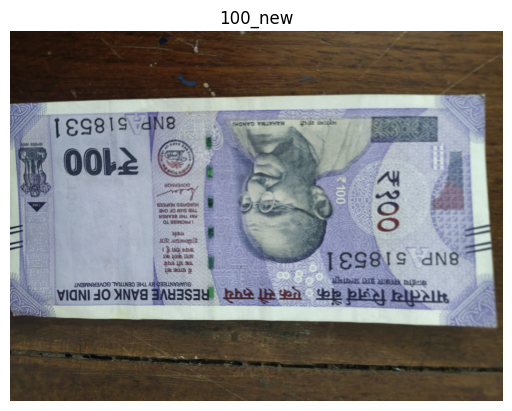

In [9]:
for i in range(1,2):
    img_n = view_random_image(target_dir='output/train/', target_class='100_new')

In [10]:
# Sets the global random seed.
tf.random.set_seed(46)

# preprocess data
train_datagen = ImageDataGenerator(rescale=1/255.0,
                                   rotation_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   vertical_flip=True,
                                   horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1/255.0)
test_datagen = ImageDataGenerator(rescale=1/255.0)

In [11]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=46)

valid_data = valid_datagen.flow_from_directory(val_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=46)

test_data = test_datagen.flow_from_directory(test_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=46)

Found 375 images belonging to 5 classes.
Found 100 images belonging to 5 classes.
Found 25 images belonging to 5 classes.


In [12]:
train_data.class_indices

{'100_new': 0, '200_new': 1, '20_new': 2, '500_new': 3, '50_new': 4}

In [13]:
train_y=train_data.classes
val_y=valid_data.classes
test_y=test_data.classes

In [14]:
print("train_y.shape: ", train_y.shape)
print("val_y.shape: ", val_y.shape)
print("test_y.shape: ", test_y.shape)

train_y.shape:  (375,)
val_y.shape:  (100,)
test_y.shape:  (25,)


In [15]:
base_model = tf.keras.applications.DenseNet121(input_shape=(224, 224, 3),
                                                        include_top=False,
                                                        weights='imagenet')
base_model.trainable = False

In [16]:
global_average_layer = GlobalAveragePooling2D()
prediction_layer = Dense(5)
softmax = Activation('softmax')

inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = Dropout(0.25)(x)
x = global_average_layer(x)
outputs = prediction_layer(x)
outputs = softmax(outputs)

model = Model(inputs, outputs)

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 dropout (Dropout)           (None, 7, 7, 1024)        0         
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 5)                 5125      
                                                                 
 activation (Activation)     (None, 5)                 0         
                                                             

In [18]:
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [19]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

# train model
history = model.fit(train_data, epochs=20, validation_data=valid_data)

Epoch 1/20


6/6 [==============================] - 81s 13s/step - loss: 1.8883 - accuracy: 0.2053 - val_loss: 1.7262 - val_accuracy: 0.2300
Epoch 2/20
6/6 [==============================] - 62s 10s/step - loss: 1.7456 - accuracy: 0.2427 - val_loss: 1.5791 - val_accuracy: 0.2900
Epoch 3/20
6/6 [==============================] - 67s 12s/step - loss: 1.5104 - accuracy: 0.3573 - val_loss: 1.4144 - val_accuracy: 0.3500
Epoch 4/20
6/6 [==============================] - 67s 11s/step - loss: 1.4013 - accuracy: 0.3973 - val_loss: 1.3186 - val_accuracy: 0.4100
Epoch 5/20
6/6 [==============================] - 68s 11s/step - loss: 1.3163 - accuracy: 0.4453 - val_loss: 1.2194 - val_accuracy: 0.5500
Epoch 6/20
6/6 [==============================] - 69s 12s/step - loss: 1.2141 - accuracy: 0.5573 - val_loss: 1.1407 - val_accuracy: 0.5800
Epoch 7/20
6/6 [==============================] - 71s 12s/step - loss: 1.1356 - accuracy: 0.6027 - val_loss: 1.0674 - val_accuracy: 0.6600
Epoch 8/20
6/6 [=========

In [23]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(loss))

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title("Loss Curves")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title("Accuracy Curves")
  plt.xlabel("Epochs")
  plt.legend()

In [24]:
val_pred = model.predict(valid_data)
val_pred = val_pred.argmax(axis=1)
print(classification_report(val_pred, val_y))

2/2 [==============================] - 12s 3s/step
              precision    recall  f1-score   support

           0       0.70      1.00      0.82        14
           1       0.80      0.89      0.84        18
           2       0.75      0.83      0.79        18
           3       1.00      0.87      0.93        23
           4       0.95      0.70      0.81        27

    accuracy                           0.84       100
   macro avg       0.84      0.86      0.84       100
weighted avg       0.86      0.84      0.84       100



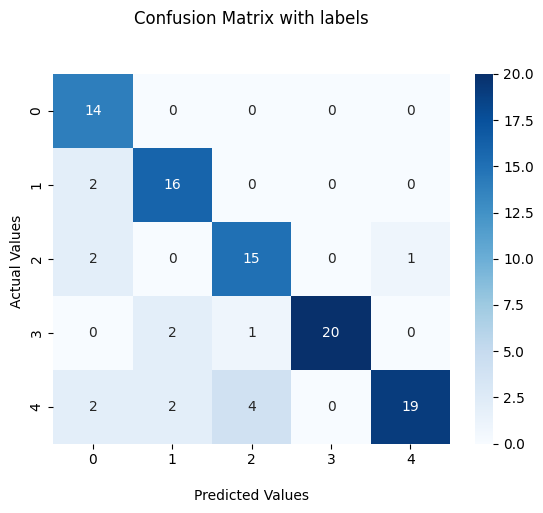

In [25]:
cfm_val = confusion_matrix(val_pred, val_y)
ax = sns.heatmap(cfm_val, annot=True, 
            cmap='Blues')

# Preparation for plotting confusion matrix
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Display the visualization of the Confusion Matrix.
plt.show()

In [26]:
test_pred = model.predict(test_data)
test_pred = test_pred.argmax(axis=1)
print(classification_report(test_pred, test_y))

1/1 [==============================] - 3s 3s/step
              precision    recall  f1-score   support

           0       0.60      1.00      0.75         3
           1       0.60      1.00      0.75         3
           2       0.80      0.67      0.73         6
           3       0.80      0.80      0.80         5
           4       1.00      0.62      0.77         8

    accuracy                           0.76        25
   macro avg       0.76      0.82      0.76        25
weighted avg       0.82      0.76      0.76        25



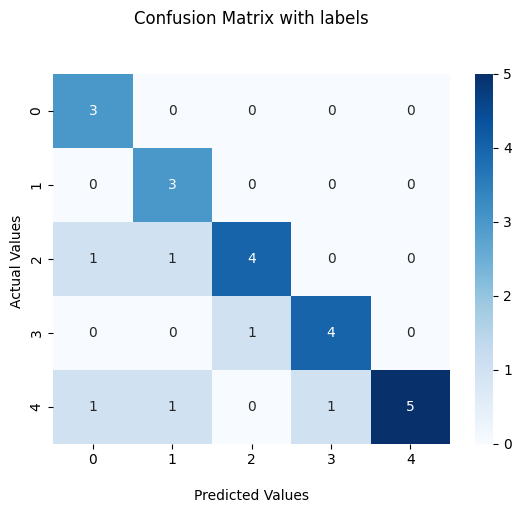

In [27]:
cfm_test = confusion_matrix(test_pred, test_y)
ax = sns.heatmap(cfm_test, annot=True, 
            cmap='Blues')

# Preparation for plotting confusion matrix
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Display the visualization of the Confusion Matrix.
plt.show()

In [28]:
model.save('my_model.keras')

In [31]:
import matplotlib.pyplot as plt
from keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk

# Define class labels
class_names = {0: '100_new', 1: '200_new', 2: '20_new', 3: '500_new', 4: '50_new'}

# Load the trained model
model = load_model('my_model.keras')

def upload_image():
    file_path = filedialog.askopenfilename()
    if not file_path:
        return
    
    img = image.load_img(file_path, target_size=(224, 224))
    img_array = np.array(img) / 255.0
    img_array = img_array.reshape(1, 224, 224, 3)
    
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_names.get(predicted_class_index, "Unknown")
    
    print("Predicted Class:", predicted_class)
    
    img_display = Image.open(file_path)
    img_display = img_display.resize((300, 300))
    img_display = ImageTk.PhotoImage(img_display)
    panel.config(image=img_display)
    panel.image = img_display
    label.config(text=f"Predicted Class: {predicted_class}")

# Create the GUI window
root = tk.Tk()
root.title("Image Classifier")

btn = tk.Button(root, text="Upload Image", command=upload_image)
btn.pack()

panel = tk.Label(root)
panel.pack()

label = tk.Label(root, text="Predicted Class: None", font=("Arial", 14))
label.pack()

root.mainloop()


In [32]:
import matplotlib.pyplot as plt
from keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk

# Define class labels
class_names = {0: '100_new', 1: '200_new', 2: '20_new', 3: '500_new', 4: '50_new'}

# Load the trained model
model = load_model('my_model.keras')

def upload_image():
    file_path = filedialog.askopenfilename()
    if not file_path:
        return
    
    img = image.load_img(file_path, target_size=(224, 224))
    img_array = np.array(img) / 255.0
    img_array = img_array.reshape(1, 224, 224, 3)
    
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_names.get(predicted_class_index, "Unknown")
    confidence = predictions[0][predicted_class_index] * 100  # Get confidence as percentage
    
    print(f"Predicted Class: {predicted_class} with {confidence:.2f}% confidence")
    
    img_display = Image.open(file_path)
    img_display = img_display.resize((300, 300))
    img_display = ImageTk.PhotoImage(img_display)
    
    panel.config(image=img_display)
    panel.image = img_display
    label.config(text=f"Predicted Class: {predicted_class}\nConfidence: {confidence:.2f}%")

# Create the GUI window
root = tk.Tk()
root.title("Image Classifier")

btn = tk.Button(root, text="Upload Image", command=upload_image)
btn.pack()

panel = tk.Label(root)
panel.pack()

label = tk.Label(root, text="Predicted Class: None\nConfidence: None", font=("Arial", 14))
label.pack()

root.mainloop()


1/1 [==============================] - 2s 2s/step
Predicted Class: 20_new with 66.37% confidence
1/1 [==============================] - 0s 94ms/step
Predicted Class: 50_new with 80.58% confidence
1/1 [==============================] - 0s 70ms/step
Predicted Class: 100_new with 70.15% confidence
1/1 [==============================] - 0s 79ms/step
Predicted Class: 200_new with 56.07% confidence
1/1 [==============================] - 0s 99ms/step
Predicted Class: 500_new with 91.55% confidence


In [35]:
import cv2
import numpy as np
import tkinter as tk
from tkinter import Label
from keras.models import load_model
from tensorflow.keras.preprocessing import image
from PIL import Image, ImageTk

# Define class labels
class_names = {0: '100_new', 1: '200_new', 2: '20_new', 3: '500_new', 4: '50_new'}

# Load the trained model
model = load_model('my_model.keras')

# Initialize the webcam
cap = cv2.VideoCapture(0)

# Function to preprocess frame and make predictions
def process_frame():
    ret, frame = cap.read()
    if not ret:
        return None, None, None
    
    # Convert the frame to grayscale for better note detection
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Use thresholding to detect edges of a note
    _, thresh = cv2.threshold(gray_frame, 200, 255, cv2.THRESH_BINARY)

    # Find contours to detect if there is a note in the frame
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Check if contours are found (indicating a note is present)
    if len(contours) == 0:
        return frame, None, None  # No note detected
    
    # Resize the frame to match the input size of the model
    img_resized = cv2.resize(frame, (224, 224))
    img_array = np.array(img_resized) / 255.0
    img_array = img_array.reshape(1, 224, 224, 3)
    
    # Make prediction
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_names.get(predicted_class_index, "Unknown")
    confidence = predictions[0][predicted_class_index] * 100  # Get confidence as percentage

    return frame, predicted_class, confidence

# Function to update the GUI with the camera feed
def update_frame():
    frame, predicted_class, confidence = process_frame()
    
    if frame is not None:
        # Convert frame to Image for Tkinter
        img_display = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img_display = Image.fromarray(img_display)
        img_display = img_display.resize((300, 300))
        img_display = ImageTk.PhotoImage(img_display)

        panel.config(image=img_display)
        panel.image = img_display
        
        if predicted_class is None:
            label.config(text="Please show a note!")
        else:
            # Update prediction text
            label.config(text=f"Predicted Class: {predicted_class}\nConfidence: {confidence:.2f}%")
    
    # Repeat the function to continuously update the frame
    root.after(10, update_frame)

# Create the GUI window
root = tk.Tk()
root.title("Real-time Note Classifier")

# Add the camera feed display panel
panel = Label(root)
panel.pack()

# Add label to display predictions
label = tk.Label(root, text="Please show a note!", font=("Arial", 14))
label.pack()

# Start the real-time update
update_frame()

root.mainloop()

# Release the camera feed when the window is closed
cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 95ms/step
